# Feature extraction using SIFT

In this notebook, we compute the feature for the day 4 bright-field image patches of nephric differentiation. We use the "bag-of-keypoints" representation, where the keypoints and their descriptors are derived from SIFT. We finally visualize the feature space using t-SNE (**Supplementary Fig. S15d**). 

In [1]:
import glob, os
import pandas as pd
import numpy as np
import random

import sklearn
from sklearn.model_selection import train_test_split

In [2]:
# set the random seed to ensure that the results are reproducible

seed = 12345
random.seed(seed)
np.random.seed(seed)

## Dataset preparation

We have cropped the whole-well images (of size 12096×12096 pixels) into non-overlapping patches (of size 800×800 pixels), and labeled them with "low", "optimal", and "high". The image patches are stored in `./image_patches./(low|optimal|high)/S*/patch*.png`, where `S*` is the index of the well where it belongs. Now we load the image patches and randomly divide them into a training set and a test set.

In [3]:
# load the directories of image patches

category = ["low", "optimal", "high"]

data = []

for c in category:
    for filename in glob.glob("./image_patches/%s/*/*.png" % (c, )):
        well_id = os.path.split(os.path.split(filename)[0])[1]
        data.append( (filename, well_id, c) )

# create a pandas DataFrame
df = pd.DataFrame(data, columns = ["filedir", "S_id", "label"])

df

,filedir,S_id,label
0,./image_patches/low\S01\patch01.png,S01,low
1,./image_patches/low\S01\patch02.png,S01,low
2,./image_patches/low\S01\patch03.png,S01,low
3,./image_patches/low\S01\patch04.png,S01,low
4,./image_patches/low\S01\patch05.png,S01,low
...,...,...,...
4850,./image_patches/high\S34\patch95.png,S34,high
4851,./image_patches/high\S34\patch96.png,S34,high
4852,./image_patches/high\S34\patch97.png,S34,high
4853,./image_patches/high\S34\patch98.png,S34,high


In [4]:
# split the dataset into a training set and a test set
df_train, df_test = train_test_split(df, train_size=0.7, random_state=seed)

print("Training set n = ", len(df_train))
print("Test set n = ", len(df_test))

Training set n =  3398
Test set n =  1457


In [5]:
# save the dataset

df.to_csv("dataset.csv")
df.to_pickle("dataset.pkl")

df_train.to_csv("dataset_train.csv")
df_train.to_pickle("dataset_train.pkl")

df_test.to_csv("dataset_test.csv")
df_test.to_pickle("dataset_test.pkl")

## Feature extraction

We then define a feature extraction module named `SIFT_feature`, with method `.fit()` and `.transform()`, following the convention of the machine learning modules in the `sklearn` package. The details about the class `SIFT_feature` can be viewed in [algutils.py](./algutils.py).

**Note:** This section may take a long time (~1-2 hours). We have provided our precomputed SIFT features in the dataframe `dataset_train_with_SIFT.pkl`, so you can simply skip this section and jump to run the next section "Feature visualization".

In [5]:
from algutils import SIFT_feature

In [6]:
sift = SIFT_feature(random_state = seed)

In [7]:
# fit the feature extractor on the training set.

sift.fit(df_train["filedir"])

  0%|                                                                                 | 1/3398 [00:00<07:44,  7.32it/s]

Compute SIFT ...


100%|██████████████████████████████████████████████████████████████████████████████| 3398/3398 [09:58<00:00,  5.68it/s]


Perform Kmeans ...
Done.


In [8]:
# save the feature extractor to disk

sift.save("feature_extractor.pkl")

In [9]:
# compute features on the training set

print("Compute features for the training set...")
df_train.loc[:, "feature_SIFT"] = list( sift.transform(df_train["filedir"]) )

  0%|                                                                                 | 1/3398 [00:00<06:19,  8.94it/s]

Compute features for the training set...


100%|██████████████████████████████████████████████████████████████████████████████| 3398/3398 [14:25<00:00,  3.92it/s]
d:\python\python39\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [10]:
# update the training dataset

df_train.to_csv("dataset_train_with_SIFT.csv")
df_train.to_pickle("dataset_train_with_SIFT.pkl")

## Feature visualization

We further visualize the feature space using t-SNE (**Supplementary Fig. S15d**). One can see that the STFT local features can clearly separate the "low", "optimal", and "high" groups.

In [6]:
from sklearn.manifold import TSNE

df_train = pd.read_pickle("./dataset_train_with_SIFT.pkl")

# Perform dimensional reduction by t-SNE
tsne = TSNE(n_components=2, random_state=seed, verbose=1, perplexity=60)
X_embedded = tsne.fit_transform(np.stack(df_train["feature_SIFT"]))

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 3398 samples in 0.001s...
[t-SNE] Computed neighbors for 3398 samples in 0.460s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3398
[t-SNE] Computed conditional probabilities for sample 2000 / 3398
[t-SNE] Computed conditional probabilities for sample 3000 / 3398
[t-SNE] Computed conditional probabilities for sample 3398 / 3398
[t-SNE] Mean sigma: 0.005203
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.665642
[t-SNE] KL divergence after 1000 iterations: 0.907804


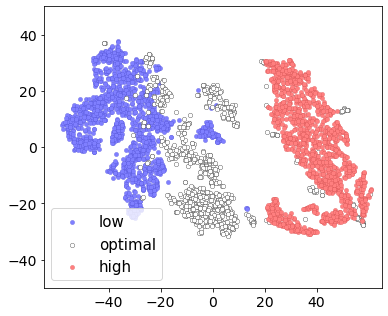

In [8]:
from matplotlib import pyplot as plt

colormap = {
    "optimal": [1, 1, 1],
    "high" : [1, 127/255, 127/255],
    "low": [127/255, 127/255, 1],
}
edgewidth = {
    "optimal": 0.3,
    "high" : 0.1,
    "low": 0.1,
}
edgecolor = {
    "optimal": "black",
    "high" : "darkred",
    "low": "darkblue",
}

plt.figure(figsize=(5.5, 4.5))

for label in ["low", "optimal", "high"]:

    plt.scatter(X_embedded[df_train.label == label, 0], 
                X_embedded[df_train.label == label, 1], 
                s = 20, alpha = 1, marker="o",
                color = colormap[label],
                linewidths=edgewidth[label], 
                edgecolors=edgecolor[label], 
                label = label,
               )

plt.xlim(-65, 65)
plt.ylim(-50, 50)
plt.legend(loc = "lower left", fontsize = 15)
plt.xticks([-40,-20, 0, 20, 40], fontsize = 14)
plt.yticks([-40, -20, 0,20, 40], fontsize = 14)
plt.tight_layout()
plt.show()